# Desafio

A empresa Você Mais Seguro fornece planos de saúde e seguros de vida. 
A empresa está interessada em lança um novo seguro de veiculos, e desja entender a propensão de compra de seus clientes para este novo cenário. 
Em uma primeira etapa, foi realizada uma grande pesquisa com seus cleintes, para entender quais destes clientes estariam interessados em adquirir o novo seguro de veiculos.

Agora, com novos clientes do plano de saude entrando para sua base, a empresa deseja entender quais destes novos clientes teriam maior propensão de compra do novo seguro de veiculos.
No entanto, a empresa não esta interessada em gastar com pesquisas para todos os novos clientes, e sim apenas para aqueles que tem maior propensão de compra, 
haja visto,que seu efetivo comercial, não é capaz de entrar em contato, para fornecer um processo de pré vendas personalizado para toda a base de seus novos clientes, somente
para 2000 deles de cada vez. 

Para isso, este projeto tem como objetivo apresentar uma lista, com os 2000 clientes com maior probabilidade de venda do seguro de veículos.

# 0.0 Imports

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

# 1.0 Limpeza dos Dados

**Tipos de limpezas**

* Nulos
* Tipagem inconsistente 
* Claros outliers (indicio de erro de digitação)


### 1.1 - Conhecendo o Dataset

In [2]:
df_raw = pd.read_csv('../data/raw/data.csv')
df_raw

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


**Features e NaN** 

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Não há NaN no dataset

----

**Descrevendo algumas features**

---- 

**Vintage:** - Tempo em dias, que o cliente esta na base da empresa.

**Policy Sales Channel** - Canal de contato com o cliente

**Vehicle_Damage:** - O Cliente ja teve algum dano em seu veiculo? 

**Previously Insured:** - O cliente já possuí algum seguro veicular?



### 1.2 - Validando os valores de cada coluna

Aqui o objetivo é compreender o valor presente em cada coluna, e se halguma coluna, não possuí algum valor de tipo inconsistente: 

**Exemplo:** idade possui valores do tipo string

In [4]:
cols_to_evaluate = df_raw.columns
cols_to_evaluate = cols_to_evaluate.drop(['id'])
cols_to_evaluate

for col in cols_to_evaluate:
    print('---'*20)
    print(col)
    print(df_raw[col].value_counts())

------------------------------------------------------------
Gender
Gender
Male      206089
Female    175020
Name: count, dtype: int64
------------------------------------------------------------
Age
Age
24    25960
23    24256
22    20964
25    20636
21    16457
      ...  
81       56
82       29
83       22
84       11
85       11
Name: count, Length: 66, dtype: int64
------------------------------------------------------------
Driving_License
Driving_License
1    380297
0       812
Name: count, dtype: int64
------------------------------------------------------------
Region_Code
Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0    

#### Conclusões

**Não foi identificada inconsistencia de tipagem**

Aqui não considerei a idade do veiculo (> 1 year...) como inconsistencia, uma vez que a ideia do campo, é realmente ser um campo do tipo texto.

### 1.3 - Identificando outliers claros que indicam falha no preenchimento dos dados

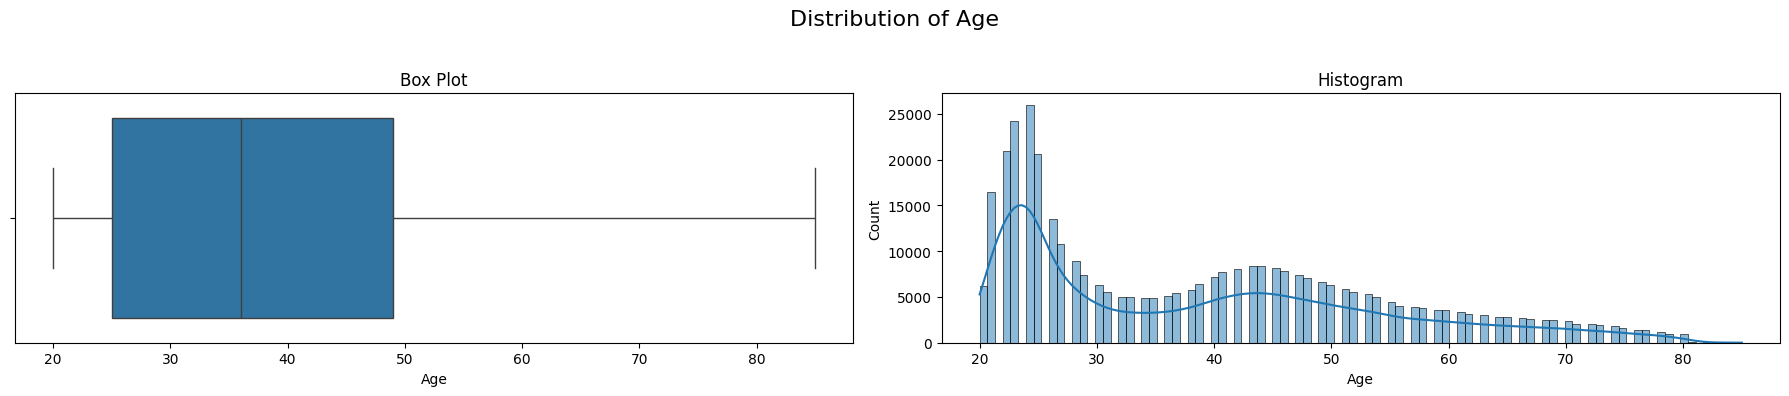

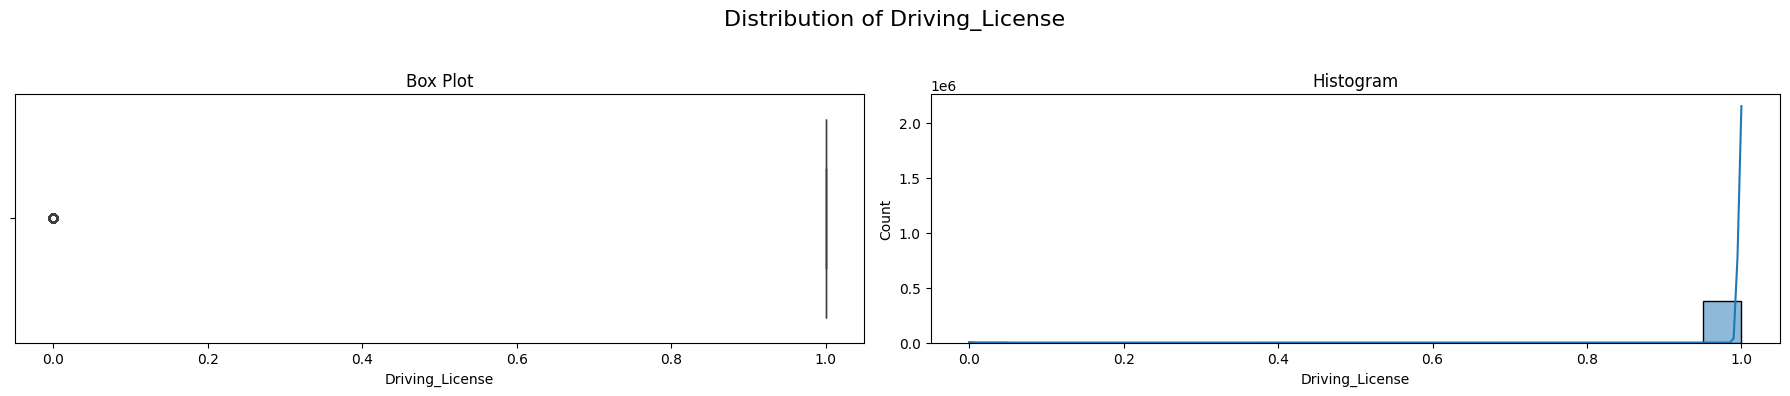

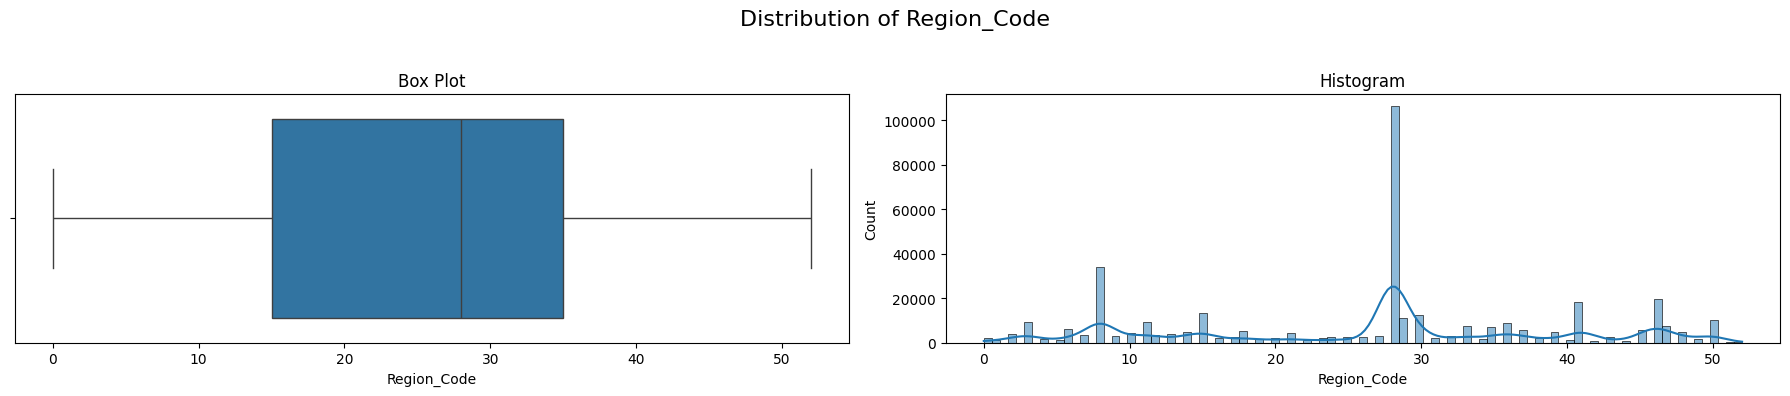

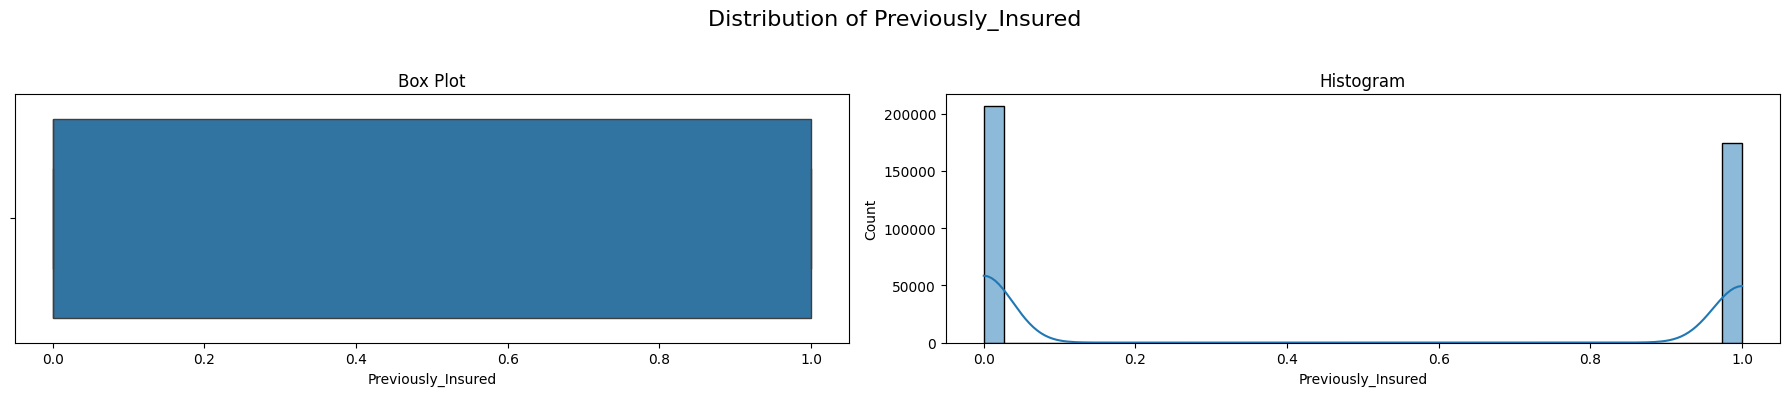

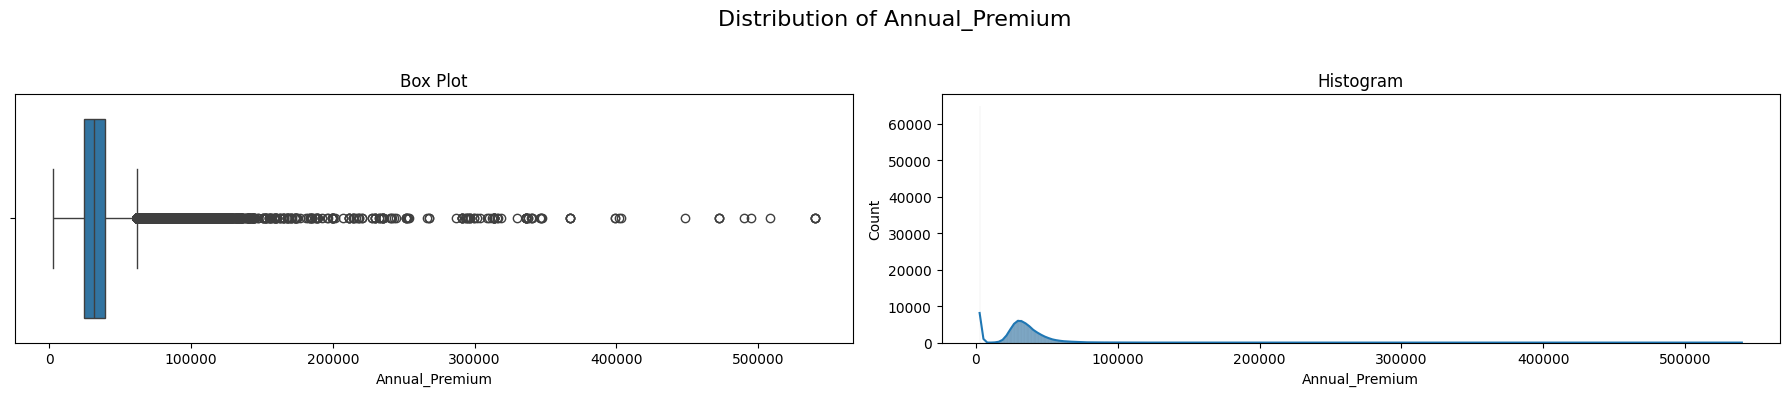

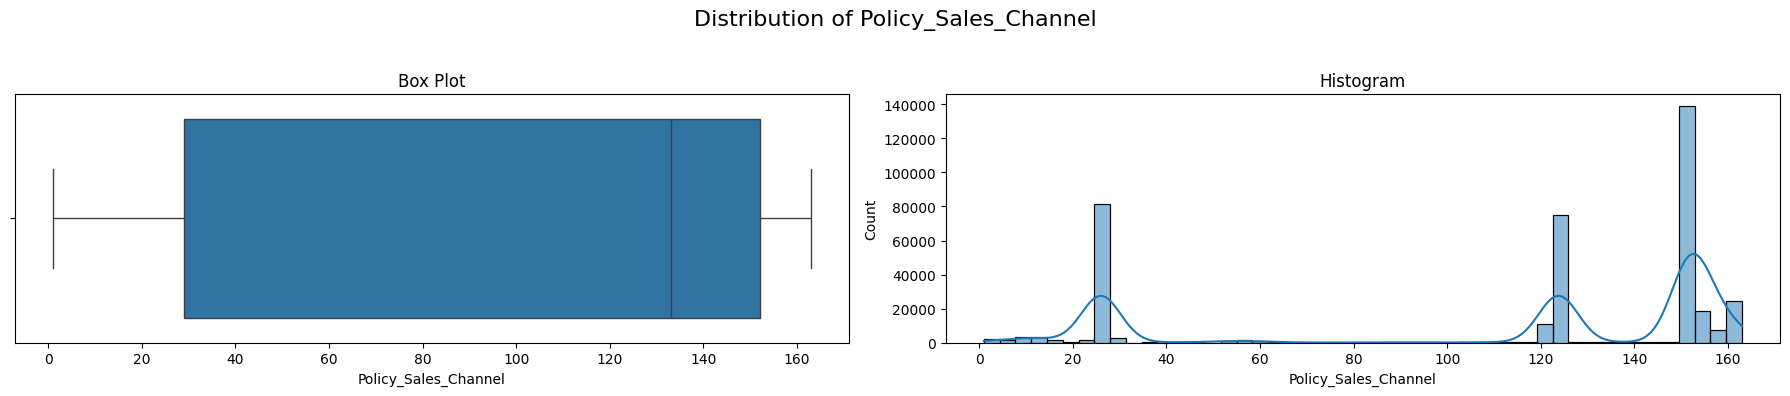

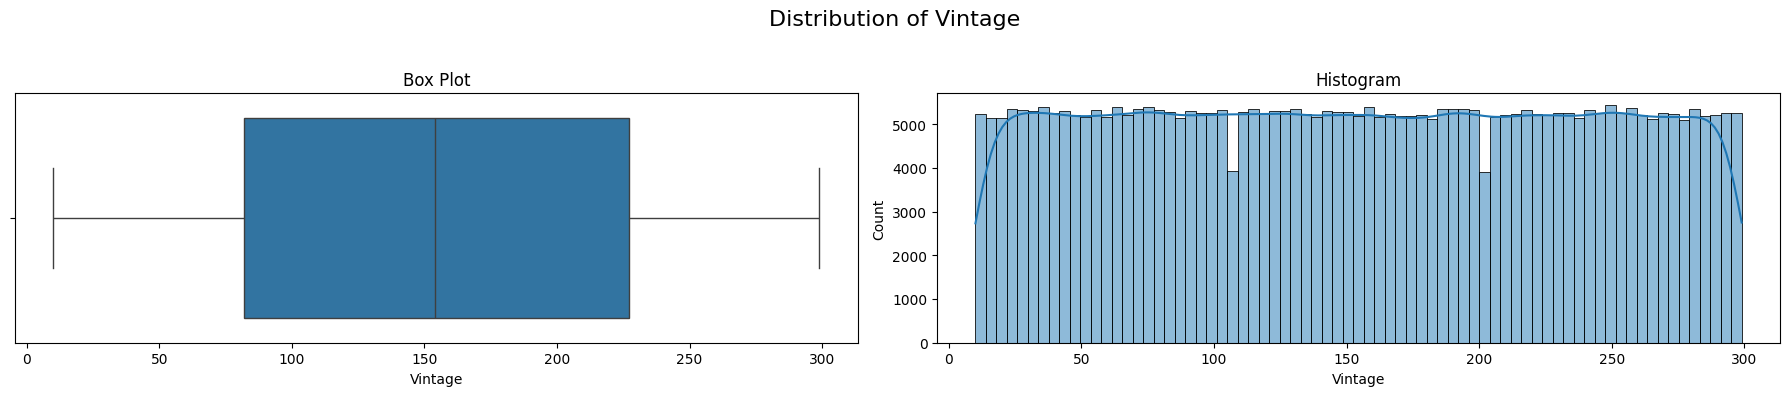

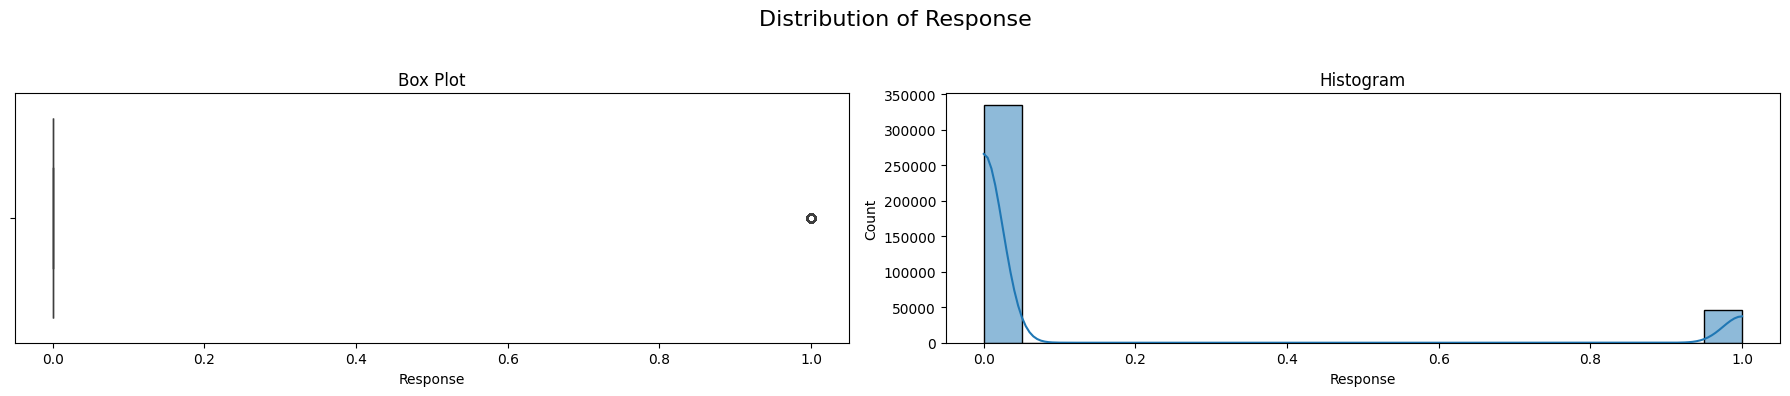

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Assuming you're using pandas

# Your DataFrame and column list would be defined here
# Example: df_raw = pd.DataFrame(...)
# Example: cols_to_evaluate = ['col_name_1', 'col_name_2']

for col in cols_to_evaluate:
    if df_raw[col].dtype in ('int64', 'float64'):
        # 1. Define the figure size
        plt.figure(figsize=(18, 4))
        
        # 2. BOXPLOT: Position 1 of 2
        plt.subplot(1, 2, 1) # <--- Corrected this to be 1, 2, 1
        sns.boxplot(x=df_raw[col])
        plt.title('Box Plot') # Optional: Add a title to the subplot
        
        # 3. HISTOGRAM: Position 2 of 2
        plt.subplot(1, 2, 2) # <--- Corrected this to be 1, 2, 2
        sns.histplot(x=df_raw[col], kde=True)
        plt.title('Histogram') # Optional: Add a title to the subplot
        
        # 4. Main title and display
        plt.suptitle(f'Distribution of {col}', fontsize=16) # Using f-string for clarity
        plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent suptitle overlap
        plt.show()

##### Conclusões

Apesar do campo Annual Premium, possuir claros outliers, isso não indica uma falha real no preenchimento dos dados, apenas expõe que existem clientes com valores de premio absurdamente maiores que outros (algo totalmente coerente/possível de ocorrer em uma seguradora de saúde)

# 2.0 Exploração dos dados

## 2.1 - Mapa de hipoteses